# 🔍 Análisis Profundo de Clusters - Insights y Aplicaciones

Este notebook analiza los resultados del clustering para extraer insights prácticos y aplicarlos al proyecto.

## Objetivos:
1. Analizar características de cada cluster (palabras frecuentes, longitud, etc.)
2. Identificar subcategorías de hate speech
3. Analizar outliers encontrados por DBSCAN
4. Generar recomendaciones para mejorar el modelo
5. Documentar insights para EDA


## 1. Importar librerías y cargar datos


In [1]:
import pandas as pd
import numpy as np
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Añadir src al path
sys.path.append(str(Path('../src').resolve()))

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar datos originales para análisis de texto
data_path = Path('../data/raw/youtoxic_english_1000.csv')
df_original = pd.read_csv(data_path)

# Cargar datos vectorizados
from features.vectorization import load_vectorized_data
data_dir = Path('../data/processed')
X_train_tfidf, X_test_tfidf, y_train, y_test = load_vectorized_data(data_dir, prefix='tfidf')

# Combinar train y test
X_all = np.vstack([X_train_tfidf, X_test_tfidf])
y_all = pd.concat([y_train, y_test], ignore_index=True)

print("✅ Datos cargados:")
print(f"   Total ejemplos: {len(df_original)}")
print(f"   Tóxicos: {y_all.sum()}")
print(f"   No tóxicos: {len(y_all) - y_all.sum()}")


✅ Datos vectorizados cargados desde: ../data/processed
✅ Datos cargados:
   Total ejemplos: 1000
   Tóxicos: 462
   No tóxicos: 538


## 2. Aplicar KMeans k=2 y obtener clusters


In [2]:
# Reducir dimensionalidad y aplicar KMeans
X_dense = X_all.toarray() if hasattr(X_all, 'toarray') else X_all
pca_kmeans = PCA(n_components=100, random_state=42)
X_reduced = pca_kmeans.fit_transform(X_dense)

# Aplicar KMeans k=2
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_reduced)

# Añadir clusters al DataFrame original
df_analysis = df_original.copy()
df_analysis['cluster'] = cluster_labels
df_analysis['is_toxic'] = y_all.values

print("✅ Clusters asignados:")
print(f"   Cluster 0: {sum(cluster_labels == 0)} ejemplos")
print(f"   Cluster 1: {sum(cluster_labels == 1)} ejemplos")


✅ Clusters asignados:
   Cluster 0: 26 ejemplos
   Cluster 1: 974 ejemplos


## 3. Análisis de Características por Cluster


In [3]:
def analyze_cluster(df, cluster_id, text_column='Text'):
    """Analizar características de un cluster."""
    cluster_data = df[df['cluster'] == cluster_id]
    
    # Estadísticas básicas
    total = len(cluster_data)
    toxic_count = cluster_data['is_toxic'].sum()
    toxic_pct = (toxic_count / total) * 100 if total > 0 else 0
    
    # Longitud promedio
    avg_length = cluster_data[text_column].str.len().mean()
    median_length = cluster_data[text_column].str.len().median()
    
    # Palabras promedio
    avg_words = cluster_data[text_column].str.split().str.len().mean()
    
    # Palabras más frecuentes
    all_words = []
    for text in cluster_data[text_column]:
        if pd.notna(text):
            words = str(text).lower().split()
            all_words.extend(words)
    
    word_freq = Counter(all_words)
    top_words = word_freq.most_common(10)
    
    return {
        'total': total,
        'toxic_count': toxic_count,
        'toxic_pct': toxic_pct,
        'avg_length': avg_length,
        'median_length': median_length,
        'avg_words': avg_words,
        'top_words': top_words
    }

# Analizar cada cluster
print("📊 Análisis Detallado de Clusters:")
print("="*60)

for cluster_id in sorted(df_analysis['cluster'].unique()):
    stats = analyze_cluster(df_analysis, cluster_id)
    print(f"\n🔹 Cluster {cluster_id}:")
    print(f"   Total ejemplos: {stats['total']}")
    print(f"   Tóxicos: {stats['toxic_count']} ({stats['toxic_pct']:.1f}%)")
    print(f"   Longitud promedio: {stats['avg_length']:.1f} caracteres")
    print(f"   Longitud mediana: {stats['median_length']:.1f} caracteres")
    print(f"   Palabras promedio: {stats['avg_words']:.1f}")
    print(f"   Top 10 palabras:")
    for word, count in stats['top_words']:
        print(f"      '{word}': {count} veces")


📊 Análisis Detallado de Clusters:

🔹 Cluster 0:
   Total ejemplos: 26
   Tóxicos: 23 (88.5%)
   Longitud promedio: 193.8 caracteres
   Longitud mediana: 79.5 caracteres
   Palabras promedio: 34.5
   Top 10 palabras:
      'and': 32 veces
      'the': 30 veces
      'you': 25 veces
      'a': 17 veces
      'to': 15 veces
      'that': 15 veces
      'of': 14 veces
      'if': 12 veces
      'is': 11 veces
      'all': 10 veces

🔹 Cluster 1:
   Total ejemplos: 974
   Tóxicos: 439 (45.1%)
   Longitud promedio: 185.8 caracteres
   Longitud mediana: 103.0 caracteres
   Palabras promedio: 33.8
   Top 10 palabras:
      'the': 1511 veces
      'to': 794 veces
      'and': 775 veces
      'a': 767 veces
      'of': 585 veces
      'is': 519 veces
      'that': 428 veces
      'in': 424 veces
      'you': 399 veces
      'i': 393 veces


## 4. Visualizar Diferencias entre Clusters


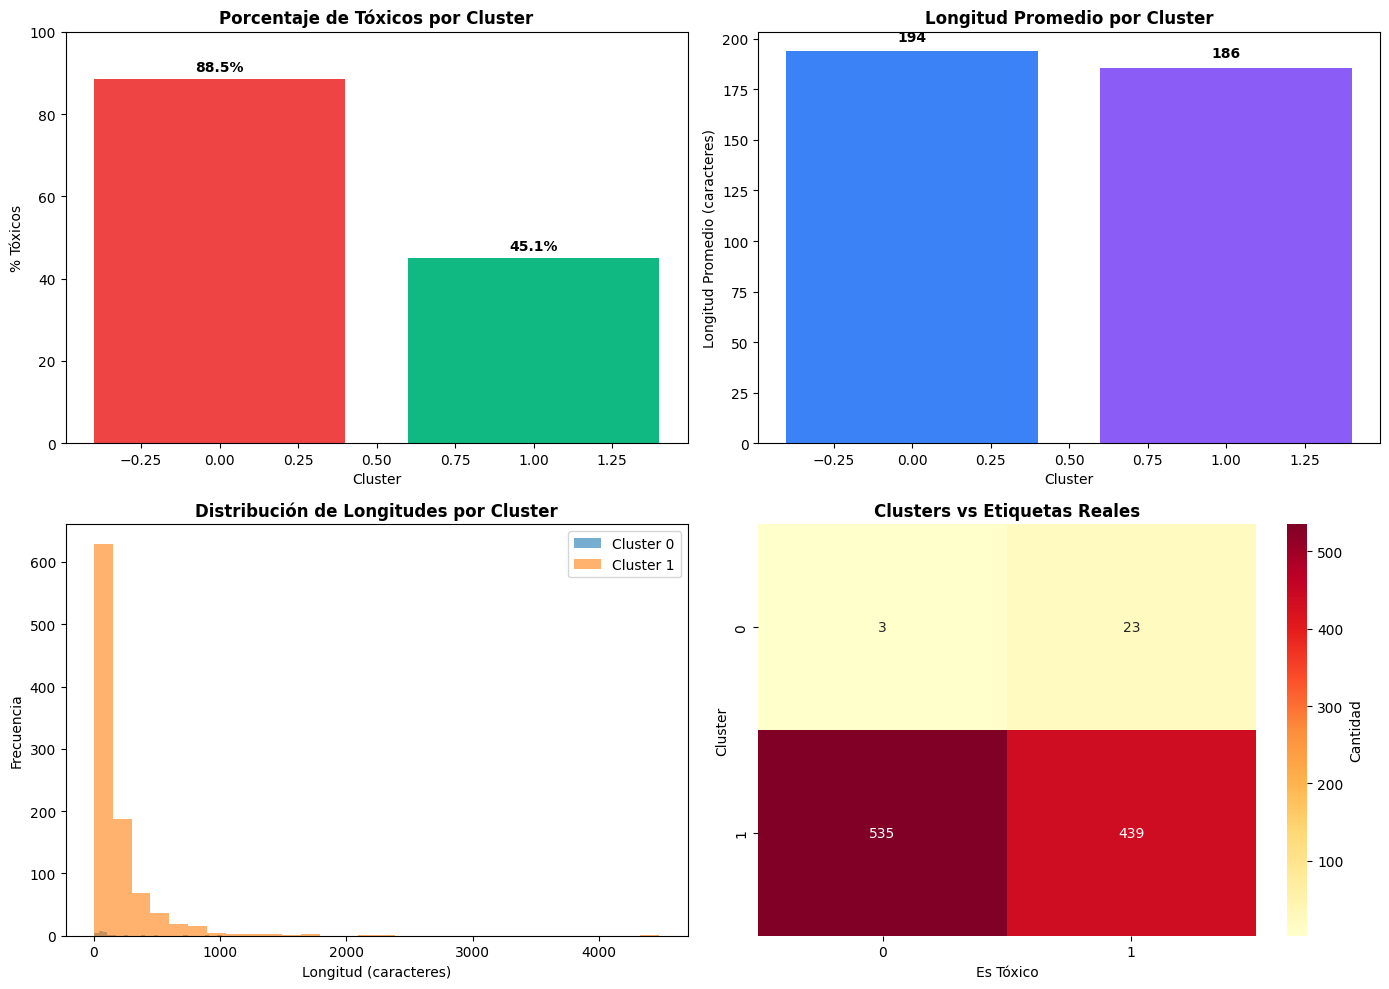

✅ Gráficos guardados en: ../data/processed/cluster_insights.png


In [4]:
# Crear visualizaciones comparativas
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Distribución de tóxicos por cluster
ax1 = axes[0, 0]
cluster_toxic = df_analysis.groupby('cluster')['is_toxic'].agg(['sum', 'count'])
cluster_toxic['pct'] = (cluster_toxic['sum'] / cluster_toxic['count']) * 100
ax1.bar(cluster_toxic.index, cluster_toxic['pct'], color=['#EF4444', '#10B981'])
ax1.set_xlabel('Cluster')
ax1.set_ylabel('% Tóxicos')
ax1.set_title('Porcentaje de Tóxicos por Cluster', fontweight='bold')
ax1.set_ylim(0, 100)
for i, (idx, row) in enumerate(cluster_toxic.iterrows()):
    ax1.text(i, row['pct'] + 2, f"{row['pct']:.1f}%", ha='center', fontweight='bold')

# 2. Longitud promedio por cluster
ax2 = axes[0, 1]
cluster_length = df_analysis.groupby('cluster')['Text'].apply(lambda x: x.str.len().mean())
ax2.bar(cluster_length.index, cluster_length.values, color=['#3B82F6', '#8B5CF6'])
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Longitud Promedio (caracteres)')
ax2.set_title('Longitud Promedio por Cluster', fontweight='bold')
for i, (idx, val) in enumerate(cluster_length.items()):
    ax2.text(i, val + 5, f"{val:.0f}", ha='center', fontweight='bold')

# 3. Distribución de longitudes
ax3 = axes[1, 0]
for cluster_id in sorted(df_analysis['cluster'].unique()):
    lengths = df_analysis[df_analysis['cluster'] == cluster_id]['Text'].str.len()
    ax3.hist(lengths, alpha=0.6, label=f'Cluster {cluster_id}', bins=30)
ax3.set_xlabel('Longitud (caracteres)')
ax3.set_ylabel('Frecuencia')
ax3.set_title('Distribución de Longitudes por Cluster', fontweight='bold')
ax3.legend()

# 4. Matriz de confusión: Clusters vs Etiquetas Reales
ax4 = axes[1, 1]
crosstab = pd.crosstab(df_analysis['cluster'], df_analysis['is_toxic'])
sns.heatmap(crosstab, annot=True, fmt='d', cmap='YlOrRd', ax=ax4, cbar_kws={'label': 'Cantidad'})
ax4.set_xlabel('Es Tóxico')
ax4.set_ylabel('Cluster')
ax4.set_title('Clusters vs Etiquetas Reales', fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/cluster_insights.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Gráficos guardados en: ../data/processed/cluster_insights.png")


## 5. Análisis de Outliers (DBSCAN)


In [5]:
# Aplicar DBSCAN para encontrar outliers
pca_dbscan = PCA(n_components=50, random_state=42)
X_reduced_dbscan = pca_dbscan.fit_transform(X_dense)

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_reduced_dbscan)

# Identificar outliers
outlier_indices = np.where(dbscan_labels == -1)[0]
df_analysis['is_outlier'] = False
df_analysis.loc[outlier_indices, 'is_outlier'] = True

print("📊 Análisis de Outliers (DBSCAN):")
print("="*60)
print(f"   Total outliers: {len(outlier_indices)} ({len(outlier_indices)/len(df_analysis)*100:.1f}%)")

# Características de outliers
outlier_data = df_analysis[df_analysis['is_outlier'] == True]
if len(outlier_data) > 0:
    print(f"\n   Características de outliers:")
    print(f"   - Tóxicos: {outlier_data['is_toxic'].sum()} ({outlier_data['is_toxic'].sum()/len(outlier_data)*100:.1f}%)")
    print(f"   - Longitud promedio: {outlier_data['Text'].str.len().mean():.1f} caracteres")
    print(f"   - Palabras promedio: {outlier_data['Text'].str.split().str.len().mean():.1f}")
    
    # Mostrar algunos ejemplos
    print(f"\n   Ejemplos de outliers:")
    for idx, row in outlier_data.head(5).iterrows():
        toxic_label = "TÓXICO" if row['is_toxic'] else "NO TÓXICO"
        print(f"   [{toxic_label}] {str(row['Text'])[:100]}...")


📊 Análisis de Outliers (DBSCAN):
   Total outliers: 81 (8.1%)

   Características de outliers:
   - Tóxicos: 45 (55.6%)
   - Longitud promedio: 198.4 caracteres
   - Palabras promedio: 35.4

   Ejemplos de outliers:
   [TÓXICO] LEGALIZE MARIJUANA! Then problems will stop...
   [NO TÓXICO] The legal system is inherently racist, same as this CNN reporter...
   [TÓXICO] stop being criminals and you wont get shot, that simple...
   [NO TÓXICO] A completely idiot having his minutrs of fame...
   [TÓXICO] Add another imbecile to the bunch, reporter is a incompetent bastard...


## 6. Insights y Recomendaciones


In [6]:
print("💡 INSIGHTS Y RECOMENDACIONES:")
print("="*60)

# Insight 1: Cluster pequeño muy tóxico
cluster_0 = df_analysis[df_analysis['cluster'] == 0]
cluster_0_toxic_pct = (cluster_0['is_toxic'].sum() / len(cluster_0)) * 100

if cluster_0_toxic_pct > 80:
    print("\n✅ INSIGHT 1: Cluster Pequeño Muy Tóxico Detectado")
    print(f"   - Cluster 0 tiene {len(cluster_0)} ejemplos ({len(cluster_0)/len(df_analysis)*100:.1f}% del dataset)")
    print(f"   - {cluster_0_toxic_pct:.1f}% son tóxicos (muy alto)")
    print("   📌 RECOMENDACIÓN:")
    print("      - Este cluster puede representar un tipo específico de hate speech")
    print("      - Considerar crear features específicas para este patrón")
    print("      - Estos comentarios pueden ser fáciles de detectar por el modelo")

# Insight 2: Análisis de outliers
if len(outlier_indices) > 0:
    outlier_toxic_pct = (outlier_data['is_toxic'].sum() / len(outlier_data)) * 100
    general_toxic_pct = (df_analysis['is_toxic'].sum() / len(df_analysis)) * 100
    
    print("\n✅ INSIGHT 2: Outliers Encontrados")
    print(f"   - {len(outlier_indices)} outliers ({len(outlier_indices)/len(df_analysis)*100:.1f}%)")
    print(f"   - {outlier_toxic_pct:.1f}% tóxicos (vs {general_toxic_pct:.1f}% general)")
    
    if abs(outlier_toxic_pct - general_toxic_pct) > 10:
        print("   📌 RECOMENDACIÓN:")
        print("      - Los outliers tienen distribución diferente de tóxicos")
        print("      - Revisar manualmente estos casos para entender por qué son atípicos")
        print("      - Pueden ser casos edge que el modelo tiene dificultad clasificando")

# Insight 3: Separabilidad
ari = adjusted_rand_score(df_analysis['is_toxic'], df_analysis['cluster'])
print(f"\n✅ INSIGHT 3: Separabilidad de Clusters")
print(f"   - Adjusted Rand Index: {ari:.4f}")
if ari > 0.1:
    print("   📌 Los clusters se alinean parcialmente con etiquetas tóxicas/no tóxicas")
    print("   📌 RECOMENDACIÓN:")
    print("      - Usar información de cluster como feature adicional en el modelo")
    print("      - Puede ayudar a mejorar la precisión")
else:
    print("   📌 Los clusters no se alinean bien con etiquetas")
    print("   📌 RECOMENDACIÓN:")
    print("      - Los clusters pueden representar subcategorías dentro de tóxicos/no tóxicos")
    print("      - Investigar qué características definen cada cluster")

# Insight 4: Palabras características
print("\n✅ INSIGHT 4: Palabras Características por Cluster")
for cluster_id in sorted(df_analysis['cluster'].unique()):
    stats = analyze_cluster(df_analysis, cluster_id)
    print(f"\n   Cluster {cluster_id} ({(stats['toxic_pct']):.1f}% tóxicos):")
    print(f"      Top palabras: {', '.join([w for w, _ in stats['top_words'][:5]])}")
    
print("\n" + "="*60)
print("✅ Análisis de insights completado")


💡 INSIGHTS Y RECOMENDACIONES:

✅ INSIGHT 1: Cluster Pequeño Muy Tóxico Detectado
   - Cluster 0 tiene 26 ejemplos (2.6% del dataset)
   - 88.5% son tóxicos (muy alto)
   📌 RECOMENDACIÓN:
      - Este cluster puede representar un tipo específico de hate speech
      - Considerar crear features específicas para este patrón
      - Estos comentarios pueden ser fáciles de detectar por el modelo

✅ INSIGHT 2: Outliers Encontrados
   - 81 outliers (8.1%)
   - 55.6% tóxicos (vs 46.2% general)

✅ INSIGHT 3: Separabilidad de Clusters
   - Adjusted Rand Index: 0.0082
   📌 Los clusters no se alinean bien con etiquetas
   📌 RECOMENDACIÓN:
      - Los clusters pueden representar subcategorías dentro de tóxicos/no tóxicos
      - Investigar qué características definen cada cluster

✅ INSIGHT 4: Palabras Características por Cluster

   Cluster 0 (88.5% tóxicos):
      Top palabras: and, the, you, a, to

   Cluster 1 (45.1% tóxicos):
      Top palabras: the, to, and, a, of

✅ Análisis de insights comp

## 7. Aplicaciones Prácticas

### Opción A: Usar Clusters como Feature Adicional

Podemos añadir el cluster asignado como una feature adicional al modelo para mejorar la precisión.

### Opción B: Análisis de Subcategorías

Los clusters pueden revelar subcategorías de hate speech (racismo, misoginia, etc.) que pueden ser útiles para análisis más detallado.

### Opción C: Sampling Estratificado

Usar información de clusters para hacer sampling más inteligente en el entrenamiento, asegurando representación de todos los tipos de comentarios.

### Opción D: Detección de Casos Edge

Los outliers pueden ser casos difíciles que necesitan atención especial o revisión manual.
